In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

from skimage.metrics import peak_signal_noise_ratio

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

In [2]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
if dev is 'cuda':
  dtype = torch.cuda.FloatTensor
else:
  dtype = torch.FloatTensor
print(f'Using device {device}')

Using device cpu


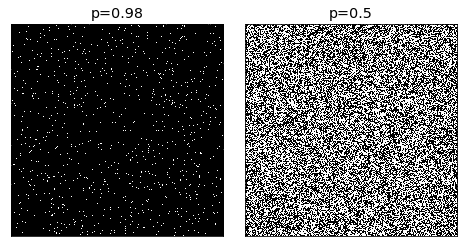

In [3]:
from utils import *
mask = torch.from_numpy(get_bernoulli_mask((3,500,500), 0.98))
mask[1] = mask[0]
mask[2] = mask[0]
mask2 = torch.from_numpy(get_bernoulli_mask((3,256,256), 0.5))
mask2[1] = mask2[0]
mask2[2] = mask2[0]
fig, axes = tensors_as_images([mask, mask2], 
                                        titles=['p=0.98', 'p=0.5'])

In [4]:
from models import *
from models.unet import *
# Change IMAGE to jet for jet image or snail for snail image
IMAGE = 'kate'

input_depth = 32
if IMAGE == 'barbara':
    net = UNet(input_depth, 1, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
elif IMAGE == 'kate':
    net = UNet(input_depth, 3, [16, 32, 64, 128, 128], [16, 32, 64, 128, 128], [0]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
else:
    assert False
net.to(device)
print(f'Image is {IMAGE}')
#print(net)

Image is kate


In [5]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 1332531


# Regular Training without input optimization

Image dim : (3, 512, 512)


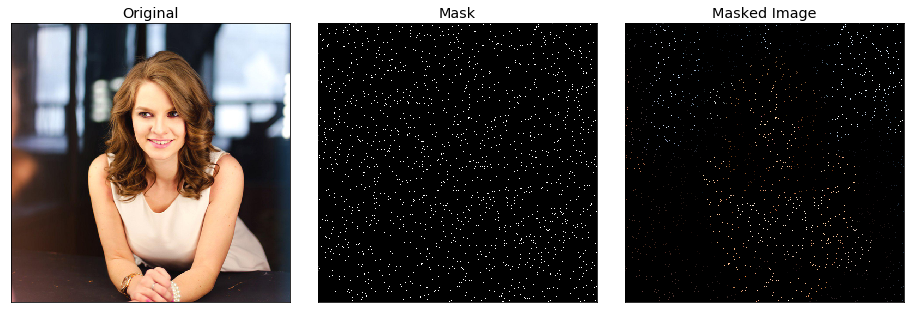

In [6]:
from utils import *
from input_gen import *

reg_noise_std = 1./30.
fname_barbara = 'data/restoration/barbara.png'
fname_kate = 'data/restoration/kate.png'
fname = fname_barbara if IMAGE == 'barbara' else fname_kate
img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np).type(dtype)
if IMAGE == 'barbara':
    img_mask_np = get_bernoulli_mask(img_np.shape, 0.5)
elif IMAGE == 'kate':
    img_mask_np = get_bernoulli_mask(img_np.shape, 0.98)
    img_mask_np[1] = img_mask_np[0]
    img_mask_np[2] = img_mask_np[0]
img_tr = torch.from_numpy(img_np).type(dtype)
mask_tr = torch.from_numpy(img_mask_np).type(dtype)
img_masked = img_np * img_mask_np
img_masked_tr = torch.from_numpy(img_masked).type(dtype)
print(f'Image dim : {img_np.shape}')
fig, axes = tensors_as_images([img_tr, mask_tr, img_masked_tr],
                              titles=['Original', 'Mask', 'Masked Image'],
                              cmap='Greys', figsize=(16,16))


In [7]:
target_img = img_masked_tr
target_img = target_img.unsqueeze(dim=0).to(device)
net_input = get_noise(input_depth, *img_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()

# HyperParmaters for each image
if IMAGE == 'barbara':
    LR = 0.001
    num_iter = 1000
    reg_noise_std = 0.03
elif IMAGE == 'kate':
    LR = 0.01
    num_iter = 1000
    reg_noise_std = 0
    
if reg_noise_std > 0:
        net_input = net_input + (noise.normal_() * reg_noise_std)
print(f'Hyperparameters : LR = {LR},  num_iter = {num_iter},  std = {reg_noise_std}')

Hyperparameters : LR = 0.01,  num_iter = 1000,  std = 0


C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


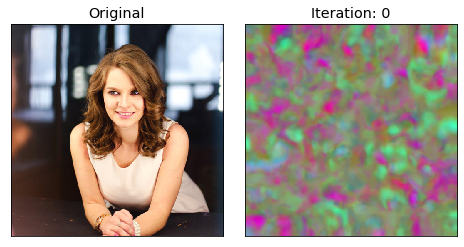

KeyboardInterrupt: 

In [8]:
# Training loop, can change hyperparameters mid way (Regular training)
parameters = [x for x in net.parameters()]
show_every = 50
optimizer = torch.optim.Adam(parameters, lr=LR)
psnr_masked_res = []
psnr_res = []
losses_res = []
for i in range(num_iter):
    optimizer.zero_grad()
    out = net(net_input)
    loss = mse(out * mask_tr.unsqueeze(dim=0).to(device), target_img)
    loss.backward()
    psnr_masked = peak_signal_noise_ratio(target_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0] * img_mask_np)
    psnr = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    psnr_masked_res.append(psnr_masked)
    psnr_res.append(psnr)
    losses_res.append(loss.item())
    optimizer.step()
    print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
          (i, loss.item(), psnr_masked, psnr), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
              (i, loss.item(), psnr_masked, psnr))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                      titles=['Original', f'Iteration: {i}'], cmap='Greys')
print(f'Done training final Loss = {loss.item()}   PSNR masked= {psnr_masked}   PSNR = {psnr}')
fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                    titles=['Original', f'Iteration: {num_iter}'], cmap='Greys')

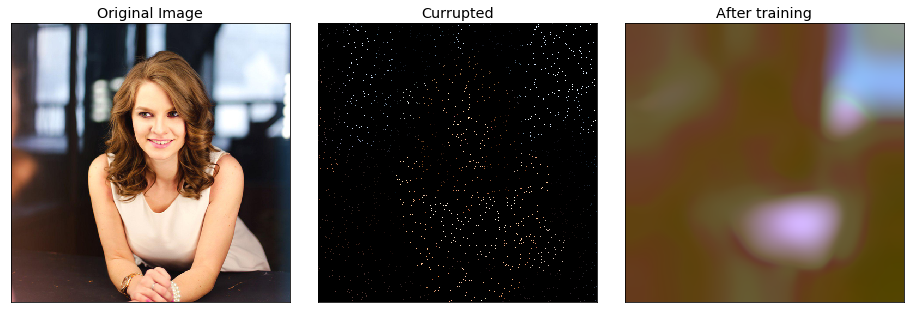

In [9]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, target_img[0], output], 
                                        titles=['Original Image', 'Currupted', 'After training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/restoration/{IMAGE}.png')
    regular_trained_output = output

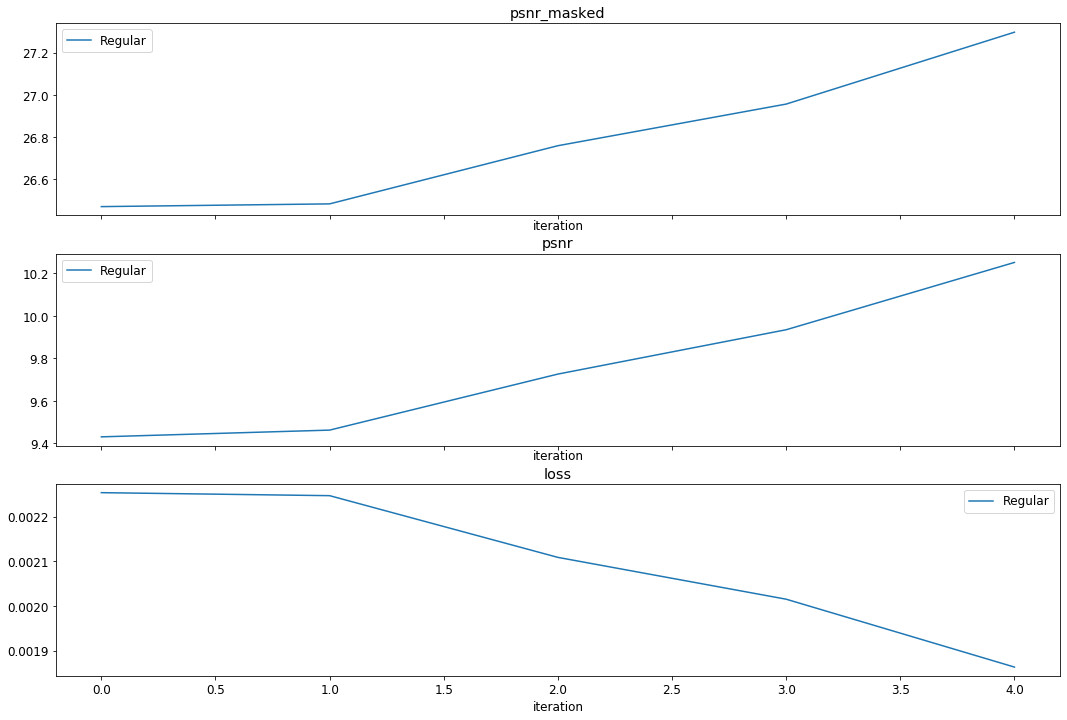

In [10]:
def plot_experiment_results(results, exp_name, fig=None):
    if fig is None:
        fig, _ = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18,12))
    for i, plot_type in enumerate(('psnr_masked', 'psnr', 'loss')):
        ax = fig.axes[i]
        if plot_type not in results:
            continue
        exp_res = results[plot_type]    
        ax.plot(list(range(len(exp_res))), exp_res, label=exp_name)
        ax.set_title(plot_type)
        ax.set_xlabel('iteration')
        ax.legend()
    return fig
    
experiments_results_fig = plot_experiment_results({'psnr': psnr_res, 'psnr_masked': psnr_masked_res, 'loss': losses_res}, 'Regular')

# Regular Training with input optimization

In [11]:
if IMAGE == 'barbara':
    net = UNet(input_depth, 1, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
elif IMAGE == 'kate':
    net = UNet(input_depth, 3, [16, 32, 64, 128, 128], [16, 32, 64, 128, 128], [0]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
else:
    assert False
net.to(device)
new_input = net_input.clone().detach()

C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


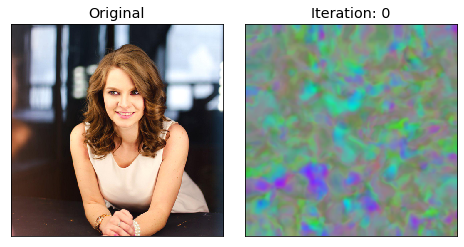

KeyboardInterrupt: 

In [12]:
# Training loop, can change hyperparameters mid way (Regular training)
parameters = [x for x in net.parameters()]
show_every = 50
optimizer = torch.optim.Adam(parameters, lr=LR)
input_optimizer = torch.optim.Adam([new_input.requires_grad_()], lr=LR)

in_opt_psnr_masked_res = []
in_opt_psnr_res = []
in_opt_losses_res = []
for i in range(num_iter):
    optimizer.zero_grad()
    input_optimizer.zero_grad()
    out = net(new_input)
    loss = mse(out * mask_tr.unsqueeze(dim=0).to(device), target_img)
    loss.backward()
    psnr_masked = peak_signal_noise_ratio(target_img.detach().cpu().numpy()[0],
                                         out.detach().cpu().numpy()[0] * img_mask_np)
    psnr = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
    in_opt_psnr_masked_res.append(psnr_masked)
    in_opt_psnr_res.append(psnr)
    in_opt_losses_res.append(loss.item())
    optimizer.step()
    input_optimizer.step()
    print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
          (i, loss.item(), psnr_masked, psnr), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
              (i, loss.item(), psnr_masked, psnr))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                      titles=['Original', f'Iteration: {i}'], cmap='Greys')
print(f'Done training final Loss = {loss.item()}   PSNR masked= {psnr_masked}   PSNR = {psnr}')
fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                    titles=['Original', f'Iteration: {num_iter}'], cmap='Greys')

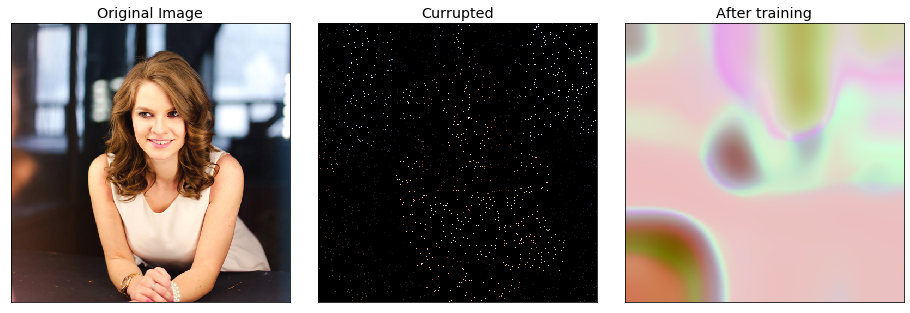

In [13]:
# Showing result of the training using original noise
with torch.no_grad():
    optimized_noise = new_input
    output = net(optimized_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, target_img[0], output], 
                                        titles=['Original Image', 'Currupted', 'After training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/restoration/{IMAGE}_input_optimization.png')
    input_optimized_trained_output = output

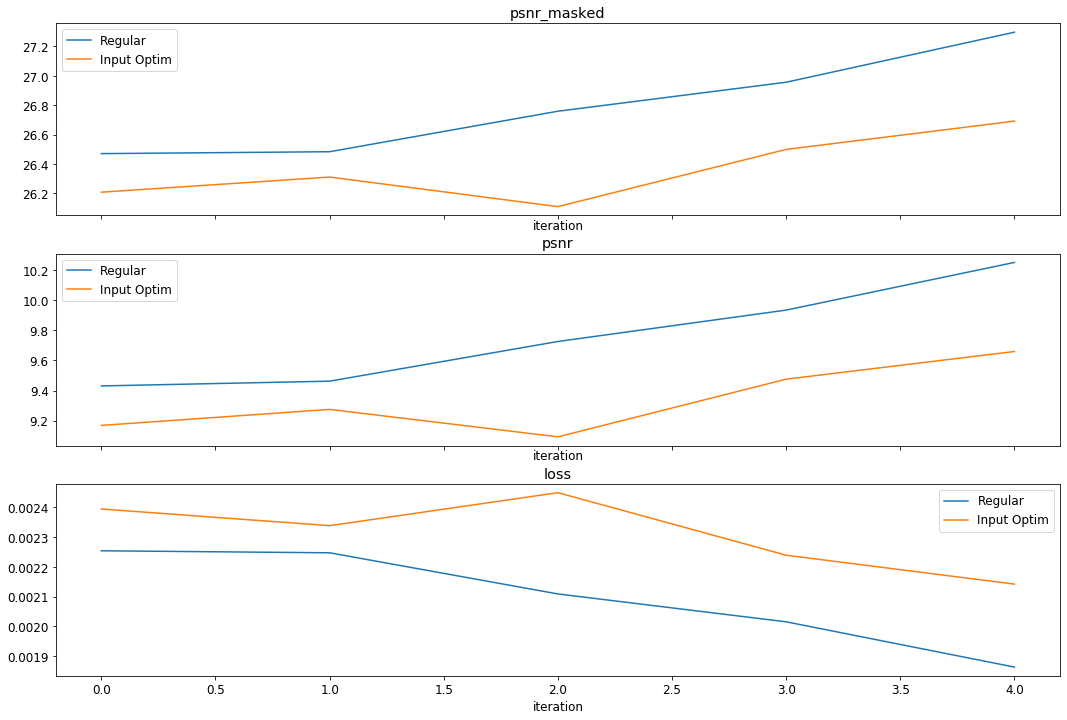

In [15]:
experiments_results_fig = plot_experiment_results({'psnr': psnr_res, 'psnr_masked': psnr_masked_res, 'loss': losses_res}, 'Regular')
experiments_results_fig = plot_experiment_results({'psnr': in_opt_psnr_res, 'psnr_masked': in_opt_psnr_masked_res, 'loss': in_opt_losses_res}, 'Input Optim', fig=experiments_results_fig);

# Adverserial training

In [16]:
from models.adverserialModel import *

# Models
if IMAGE == 'barbara':
    gen = UNet(input_depth, 1, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
elif IMAGE == 'kate':
    gen = UNet(input_depth, 3, [16, 32, 64, 128, 128], [16, 32, 64, 128, 128], [0]*5,
              [3]*5, [3]*5, [1]*5, weight_std=1./30)
else:
    assert False
    
gen.to(device)
# gen = net 
dsc = Discriminator(img_tr.shape).to(device)

# Hyperparams
DSC_LR = 0.001
GEN_LR = 0.01
DATA_LABEL = 1
LABEL_NOISE = 0.3
num_iter = 2000

# Optimizers
dsc_optimizer = torch.optim.Adam(dsc.parameters(), DSC_LR)
gen_optimizer = torch.optim.Adam(gen.parameters(), GEN_LR)

# Loss
def dsc_loss_fn(y_data, y_generated):
    return discriminator_loss_fn(y_data, y_generated, DATA_LABEL, LABEL_NOISE)

def gen_loss_fn(y_generated):
    return generator_loss_fn(y_generated, DATA_LABEL)

# Gen input
# net_input = get_noise(input_depth, *img_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
# noise = net_input.detach().clone()
# if reg_noise_std > 0:
#         net_input = net_input + (noise.normal_() * reg_noise_std)

C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  


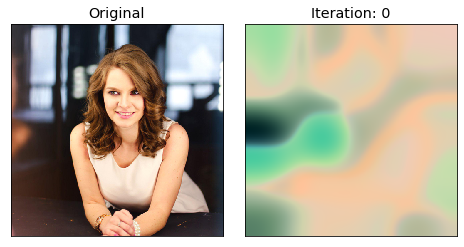

KeyboardInterrupt: 

In [19]:
def mask_fn(img, mask):
    return img * mask

# Training loop
adv_psnr_masked_res = []
adv_psnr_res = []

for i in range(num_iter):
    dsc_loss, gen_loss, output = train_batch(dsc, gen, dsc_loss_fn, gen_loss_fn,
                                    dsc_optimizer, gen_optimizer,
                                    target_img, net_input,
                                    mask_fn, mask_tr.to(device))
    psnr_masked = peak_signal_noise_ratio(target_img.detach().cpu().numpy()[0],
                                         output.detach().cpu().numpy()[0] * img_mask_np)
    psnr = peak_signal_noise_ratio(img_np, output.detach().cpu().numpy()[0]) 
    adv_psnr_masked_res.append(psnr_masked)
    adv_psnr_res.append(psnr)
    print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
          (i, gen_loss, dsc_loss, psnr_masked, psnr), '\r', end='')
    if i % show_every == 0 and i:
        print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
              (i, gen_loss, dsc_loss, psnr_masked, psnr))
    if i % (show_every*2) == 0:
        fig, axes = tensors_as_images([img_tr, output[0].detach()], 
                                      titles=['Original', f'Iteration: {i}'], cmap='Greys')
    

C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\modules\upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
C:\Users\aviv_\Miniconda3\envs\project\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


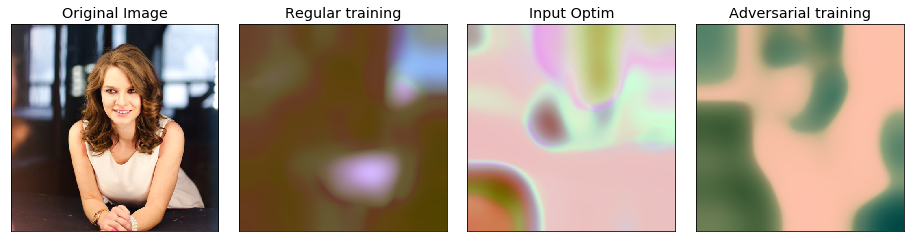

In [25]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = net_input
    output = gen(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, regular_trained_output, input_optimized_trained_output, output], 
                                        titles=['Original Image', 'Regular training', 'Input Optim', 'Adversarial training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/restoration/{IMAGE}_adversarial.png')

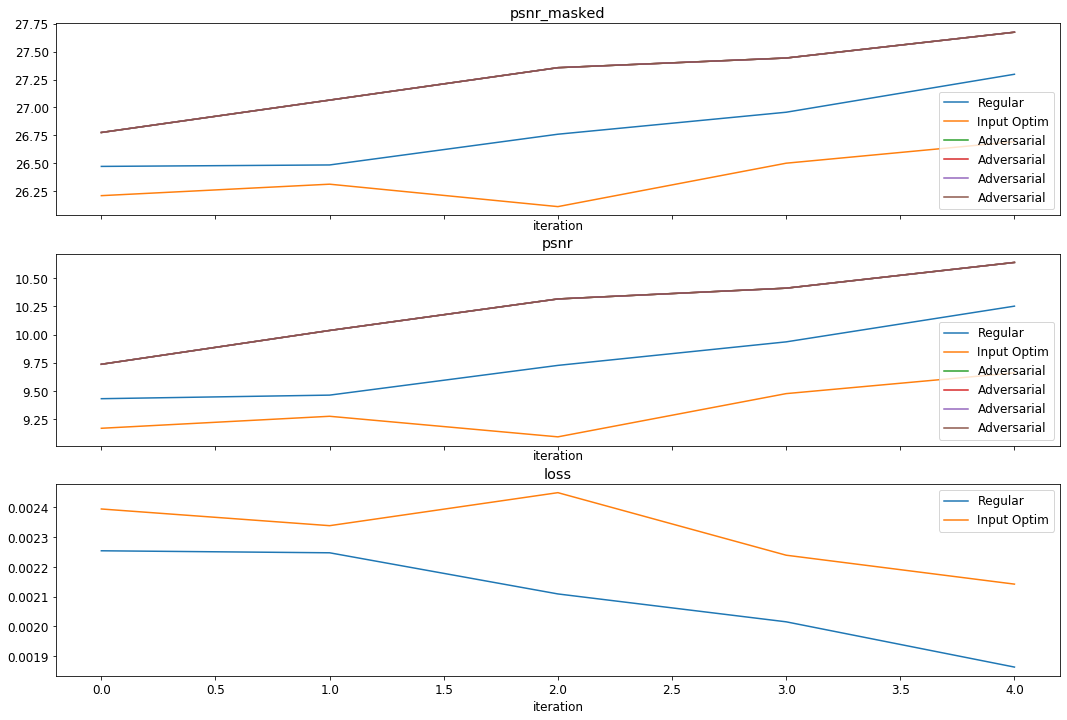

In [24]:
plot_experiment_results({'psnr': adv_psnr_res, 'psnr_masked': adv_psnr_masked_res}, 'Adversarial', fig=experiments_results_fig)